In [1]:
files = "abcdefgh"
ranks = "12345678"

def sq_name(f, r):
    return files[f] + ranks[r]

all_squares = [(f, r) for f in range(8) for r in range(8)]
moves = set()

# Sliding rays: rook + bishop (queen is included by union)
dirs_rook   = [(1,0),(-1,0),(0,1),(0,-1)]
dirs_bishop = [(1,1),(1,-1),(-1,1),(-1,-1)]

def add_rays(dirs):
    for f0, r0 in all_squares:
        for df, dr in dirs:
            for step in range(1, 8):
                f1, r1 = f0 + df*step, r0 + dr*step
                if 0 <= f1 < 8 and 0 <= r1 < 8:
                    moves.add(sq_name(f0, r0) + sq_name(f1, r1))
                else:
                    break

add_rays(dirs_rook)
add_rays(dirs_bishop)

# Knight jumps
knight = [(1,2),(2,1),(2,-1),(1,-2),(-1,-2),(-2,-1),(-2,1),(-1,2)]
for f0, r0 in all_squares:
    for df, dr in knight:
        f1, r1 = f0 + df, r0 + dr
        if 0 <= f1 < 8 and 0 <= r1 < 8:
            moves.add(sq_name(f0, r0) + sq_name(f1, r1))

# King one-step
king = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
for f0, r0 in all_squares:
    for df, dr in king:
        f1, r1 = f0 + df, r0 + dr
        if 0 <= f1 < 8 and 0 <= r1 < 8:
            moves.add(sq_name(f0, r0) + sq_name(f1, r1))

# Pawns (both colors): singles, doubles, captures (excluding promotions here)
# white moves up (r+), black moves down (r-)
for f0, r0 in all_squares:
    # White: single from ranks 2..6 (idx 1..5), double from rank 2 (idx 1)
    if 1 <= r0 <= 5:
        moves.add(sq_name(f0, r0) + sq_name(f0, r0+1))
        for df in (-1, 1):
            f1 = f0 + df
            if 0 <= f1 < 8:
                moves.add(sq_name(f0, r0) + sq_name(f1, r0+1))
    if r0 == 1:
        moves.add(sq_name(f0, r0) + sq_name(f0, r0+2))

    # Black: single from ranks 3..7 (idx 2..6), double from rank 7 (idx 6)
    if 2 <= r0 <= 6:
        moves.add(sq_name(f0, r0) + sq_name(f0, r0-1))
        for df in (-1, 1):
            f1 = f0 + df
            if 0 <= f1 < 8:
                moves.add(sq_name(f0, r0) + sq_name(f1, r0-1))
    if r0 == 6:
        moves.add(sq_name(f0, r0) + sq_name(f0, r0-2))

# Castling is encoded as king moves in UCI
for m in ["e1g1", "e1c1", "e8g8", "e8c8"]:
    moves.add(m)

# Promotions: 44 base (from,to) pairs × 4 pieces
promo_bases = set()
# White promotions: from rank 7 (idx 6) to rank 8 (idx 7)
for f0 in range(8):
    promo_bases.add(sq_name(f0, 6) + sq_name(f0, 7))      # forward
    for df in (-1, 1):                                    # captures
        f1 = f0 + df
        if 0 <= f1 < 8:
            promo_bases.add(sq_name(f0, 6) + sq_name(f1, 7))

# Black promotions: from rank 2 (idx 1) to rank 1 (idx 0)
for f0 in range(8):
    promo_bases.add(sq_name(f0, 1) + sq_name(f0, 0))
    for df in (-1, 1):
        f1 = f0 + df
        if 0 <= f1 < 8:
            promo_bases.add(sq_name(f0, 1) + sq_name(f1, 0))

all_uci = set(moves)
for base in promo_bases:
    for p in "qrbn":
        all_uci.add(base + p)

all_uci = sorted(all_uci)
print("count:", len(all_uci))     # should print 1968
print(all_uci[:5])



count: 1968
['a1a2', 'a1a3', 'a1a4', 'a1a5', 'a1a6']


In [2]:
move2id ={uci: idx for idx, uci in enumerate(all_uci)}

In [3]:
move2id['<EOS>'] = len(all_uci)
move2id['<RES_1-0>'] = len(all_uci) + 1
move2id['<RES_0-1>'] = len(all_uci) + 2
move2id['<RES_1/2-1/2>'] = len(all_uci) + 3
move2id['<PAD>'] = len(all_uci) + 4


In [4]:
id2move ={idx: uci for idx, uci in enumerate(move2id.keys())}

In [5]:
id2move[1968]

'<EOS>'

In [6]:
import chess
import chess.pgn

def pgn_to_uci_sequences(pgn_path, max_games=None):
    sequences = []
    with open(pgn_path, "r", encoding="utf-8", errors="ignore") as f:
        n = 0
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            board = game.board()
            uci_moves = []
            for move in game.mainline_moves():
                uci_moves.append(move.uci())
                board.push(move)

            # game headers contain the result
            result = game.headers.get("Result", "*")
            result = '<RES_' + result + '>'
            last_tokens = [ '<EOS>', result]
            sequences.append(uci_moves+last_tokens)

            n += 1
            if max_games and n >= max_games:
                break
    return sequences


In [7]:
games = pgn_to_uci_sequences("../RuyLopezClassical.pgn")

In [8]:
games[0]

['e2e4',
 'e7e5',
 'g1f3',
 'b8c6',
 'f1b5',
 'f8c5',
 'c2c3',
 'd8e7',
 'e1g1',
 'c6d8',
 'd2d4',
 'e5d4',
 'c3d4',
 'c5b6',
 'e4e5',
 'c7c6',
 'b5c4',
 'd7d5',
 'e5d6',
 'e7d6',
 'f1e1',
 'c8e6',
 'b2b3',
 'g8e7',
 'c1a3',
 'd6c7',
 'b1c3',
 'b6a5',
 'c4e6',
 'd8e6',
 'b3b4',
 'a5b6',
 'b4b5',
 'e8g8',
 'd1b3',
 'f8e8',
 'e1e6',
 'f7e6',
 'b3e6',
 'g8h8',
 'f3g5',
 'h7h6',
 'g5f7',
 'h8h7',
 'f7d6',
 'e8f8',
 'a1e1',
 'e7g6',
 'e1e4',
 'f8f6',
 'e6g4',
 'f6d6',
 'a3d6',
 'c7d6',
 'e4e6',
 'd6d4',
 'g4g6',
 'h7h8',
 'e6e8',
 'a8e8',
 'g6e8',
 'h8h7',
 'e8e4',
 'd4e4',
 'c3e4',
 'c6b5',
 'e4d6',
 'a7a5',
 'd6b5',
 'b6c5',
 'g1f1',
 'h7g6',
 'f1e2',
 'g6f5',
 'f2f3',
 'h6h5',
 'e2d3',
 'g7g5',
 'b5d4',
 'f5e5',
 'd4b3',
 'c5b6',
 'a2a4',
 'g5g4',
 'f3g4',
 'h5g4',
 'h2h3',
 'g4h3',
 'g2h3',
 'b6d8',
 'd3c4',
 'e5f4',
 'b3c5',
 'f4g3',
 'c5b7',
 'd8c7',
 'c4b5',
 'g3h3',
 'b5c6',
 'c7g3',
 'b7a5',
 'g3e1',
 'c6b5',
 'h3g4',
 'a5c6',
 'g4f5',
 'c6b4',
 'f5e6',
 'a4a5',
 'e6d6',
 'a5a6',
 

In [9]:
import torch
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    def __init__(self, games, move2id, block_size=128, stride=64, pad_token="<PAD>"):
        self.block_size = block_size
        self.stride = stride
        self.pad_id = move2id[pad_token]
        self.samples = []

        for game in games:
            ids = self.encode_game(game, move2id)

            # skip too-short
            if len(ids) < 2:
                continue

            T = self.block_size
            chunk_len = T + 1

            if len(ids) <= chunk_len:
                # store as-is; we will pad in __getitem__
                self.samples.append(ids)
            else:
                for start in range(0, len(ids) - chunk_len + 1, stride):
                    self.samples.append(ids[start:start + chunk_len])

    def encode_game(self, game, move2id):
        ids = []
        for uci in game:
            ids.append(move2id[uci])
        return ids
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ids = self.samples[idx]
        target_len = self.block_size + 1

        # pad/truncate window to target_len
        if len(ids) < target_len:
            ids = ids + [self.pad_id] * (target_len - len(ids))
        else:
            ids = ids[:target_len]

        ids = torch.tensor(ids, dtype=torch.long)

        x = ids[:-1]        # [T]
        y = ids[1:].clone() # [T]

        # ignore padding in loss
        y[y == self.pad_id] = -100

        # attention mask for x
        attn_mask = (x != self.pad_id).long()

        return x, y, attn_mask


In [10]:
from torch.utils.data import DataLoader

ds = SlidingWindowDataset(games, move2id, block_size=16, stride=1)
dl = DataLoader(ds, batch_size=32, shuffle=True)

x, y, mask = next(iter(dl))
print(x.shape, y.shape, mask.shape) 


torch.Size([32, 16]) torch.Size([32, 16]) torch.Size([32, 16])


In [11]:
len(dl)

11312

In [12]:
id2move[667]

'c7c6'

In [13]:
for move in x[0]:
    print(id2move[move.item()])

c6c7
e5e8
c7c8
e8c8
b8c8
f7h8
g8f6
h8g6
c8d7
f1c1
a8e8
c1d1
d7c7
g1f1
e8e6
g6f4


In [14]:
from transformers import GPT2Config, GPT2LMHeadModel

vocab_size = len(move2id)

config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=16,   # must be >= block_size
    n_ctx=16,
    n_embd=64,
    n_layer=4,
    n_head=4,
    bos_token_id=move2id.get("<BOS>", None),
    eos_token_id=move2id["<EOS>"],
)

model = GPT2LMHeadModel(config)


/home/musel/Documents/github/llm-chess/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:

id2move = {i:m for m,i in move2id.items()}

def generate_moves(model, prefix_moves, max_new_tokens=50, device="cuda"):
    model.eval()
    input_ids = torch.tensor([prefix_moves], dtype=torch.long, device=device)

    out = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        eos_token_id=move2id["<EOS>"],
        pad_token_id=move2id["<PAD>"],
    )
    return [id2move[i] for i in out[0].tolist()]


In [16]:
gen_game = generate_moves(model, [move2id['e2e4'], move2id['e7e5'], move2id['g1f3']], max_new_tokens=10, device="cpu")

e2e4


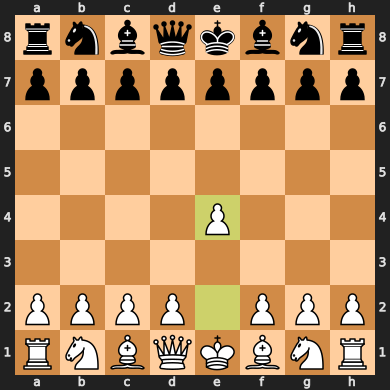

e7e5


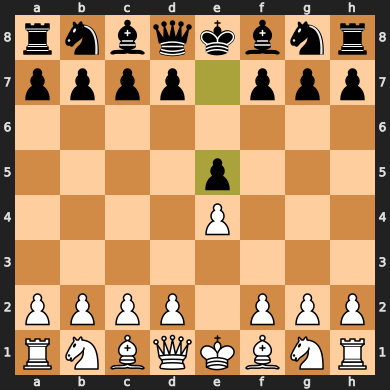

g1f3


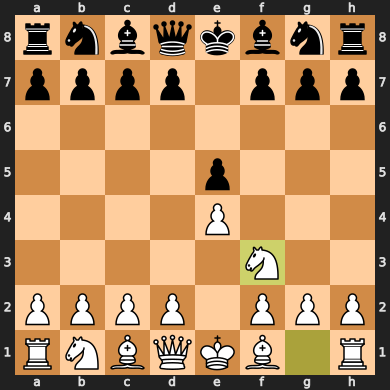

f3h5
Illegal move: f3h5


In [17]:
board = chess.Board()
for move in gen_game:
    print(move)
    chess_move = chess.Move.from_uci(move)
    if chess_move in board.legal_moves:
        board.push(chess_move)
        display(board)
    else:
        print("Illegal move:", move)
        break

In [18]:
import torch
from torch.utils.data import Dataset

def encode_game(game, move2id):
    return [move2id[m] for m in game]

class HFSwChessDataset(Dataset):
    def __init__(self, games, move2id, block_size=128, stride=64):
        self.pad_id = move2id["<PAD>"]
        self.eos_id = move2id["<EOS>"]
        self.block_size = block_size
        self.samples = []

        T = block_size

        for g in games:
            ids = encode_game(g, move2id)

            # ensure an EOS exists (skip if your data already guarantees it)
            if len(ids) == 0 or ids[-1] != self.eos_id:
                ids = ids + [self.eos_id]

            if len(ids) < 2:
                continue

            if len(ids) <= T:
                self.samples.append(ids)
            else:
                for start in range(0, len(ids) - T + 1, stride):
                    self.samples.append(ids[start:start + T])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ids = self.samples[idx]
        T = self.block_size

        if len(ids) < T:
            ids = ids + [self.pad_id] * (T - len(ids))
        else:
            ids = ids[:T]

        input_ids = torch.tensor(ids, dtype=torch.long)
        attention_mask = (input_ids != self.pad_id).long()

        labels = input_ids.clone()
        labels[labels == self.pad_id] = -100  # ignore pad in loss

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [19]:
from transformers import GPT2Config, GPT2LMHeadModel

vocab_size = len(move2id)
block_size = 32

config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=block_size,
    n_ctx=block_size,
    n_embd=128,
    n_layer=4,
    n_head=4,
    bos_token_id=None,                 # you don't have <BOS>
    eos_token_id=move2id["<EOS>"],
)

model = GPT2LMHeadModel(config)

# Important: GPT2 has no pad token by default; set it so generate() doesn't complain
model.config.pad_token_id = move2id["<PAD>"]


In [22]:
# split games into train and eval
num_games = len(games)
train_size = int(0.9 * num_games)
train_games = games[:train_size]
eval_games = games[train_size:]

In [24]:
from transformers import Trainer, TrainingArguments

# Split your games beforehand into train_games / eval_games
train_ds = HFSwChessDataset(train_games, move2id, block_size=32, stride=64)
eval_ds  = HFSwChessDataset(eval_games,  move2id, block_size=32, stride=128)

args = TrainingArguments(
    output_dir="tiny_chess_gpt2_uci",
    per_device_train_batch_size=32,     # lower if OOM
    per_device_eval_batch_size=32,
    learning_rate=3e-4,
    weight_decay=0.1,
    warmup_steps=50,
    max_steps=2000,                     # adjust
    logging_steps=5,
    eval_steps=50,
    save_steps=50,
    eval_strategy="steps",
    save_total_limit=2,
    fp16=False,                           # set False if no GPU / no fp16
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
)

trainer.train()


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
50,6.275200,5.833830
100,5.197900,4.474185
150,4.436900,3.795419
200,4.261000,3.478221
250,3.959600,3.310724
300,3.830400,3.178798
350,4.036900,3.091073
400,3.839300,3.021316
450,3.704000,2.957608
500,3.847200,2.906095


/home/musel/Documents/github/llm-chess/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/musel/Documents/github/llm-chess/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/musel/Documents/github/llm-chess/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/musel/Documents/github/llm-chess/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  

TrainOutput(global_step=2000, training_loss=3.6652987904548646, metrics={'train_runtime': 367.6368, 'train_samples_per_second': 174.085, 'train_steps_per_second': 5.44, 'total_flos': 9718451306496.0, 'train_loss': 3.6652987904548646, 'epoch': 9.523809523809524})

In [26]:

id2move = {i:m for m,i in move2id.items()}

def sample_game(model, prefix_moves_uci, move2id, max_new_tokens=60, device="cuda"):
    model.eval()
    prefix_ids = [move2id[m] for m in prefix_moves_uci]
    input_ids = torch.tensor([prefix_ids], dtype=torch.long, device=device)

    out = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        eos_token_id=move2id["<EOS>"],
        pad_token_id=move2id["<PAD>"],
    )
    return [id2move[i] for i in out[0].tolist()]


In [ ]:
[move2id['e2e4'], move2id['e7e5'], move2id['g1f3']]

In [46]:
sampled_game = sample_game(model, ['e2e4', 'e7e5', 'g1f3'], move2id, max_new_tokens=31, device="cpu")

e2e4


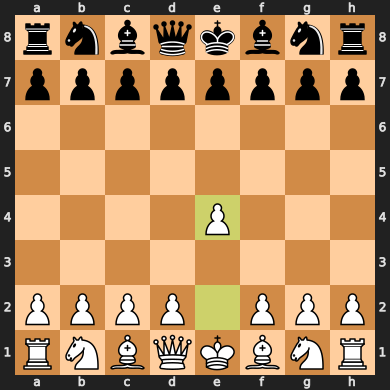

e7e5


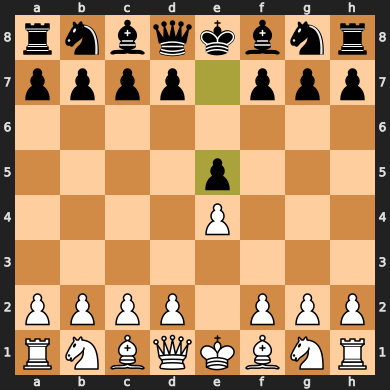

g1f3


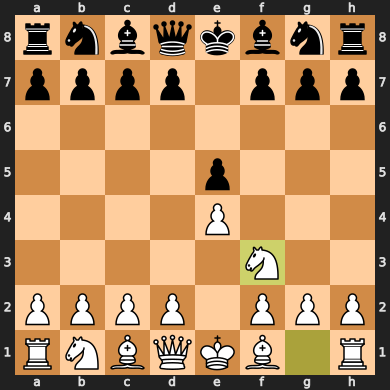

b8c6


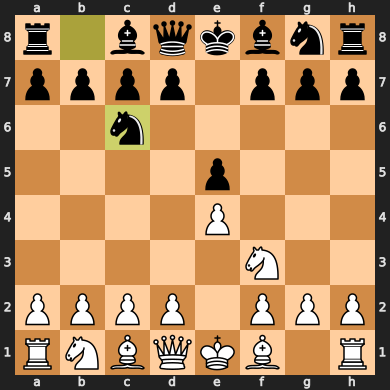

f1b5


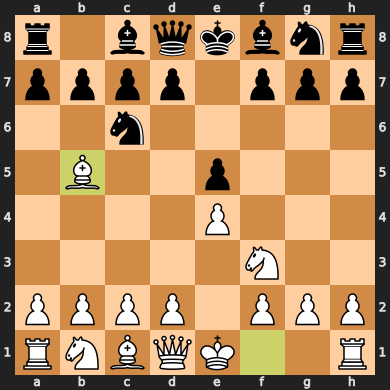

f8c5


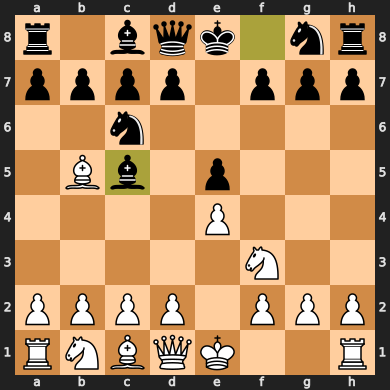

e1g1


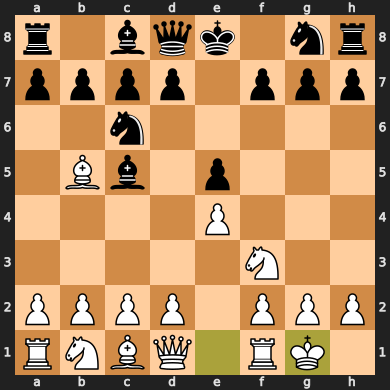

c6d4


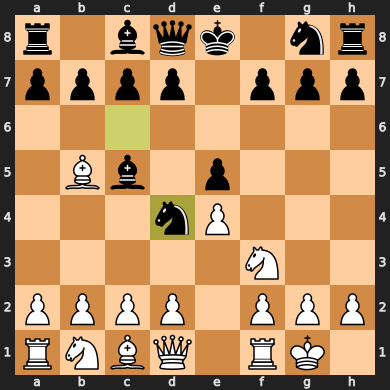

f3d4


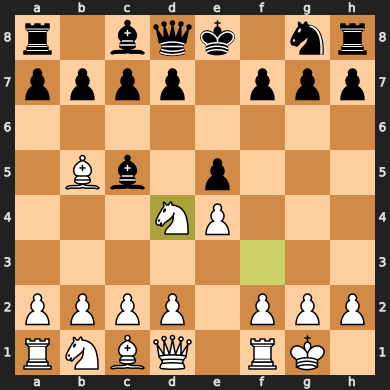

c5d4


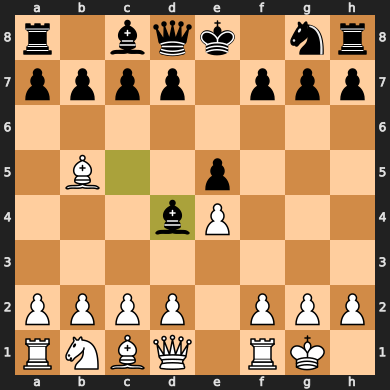

c2c3


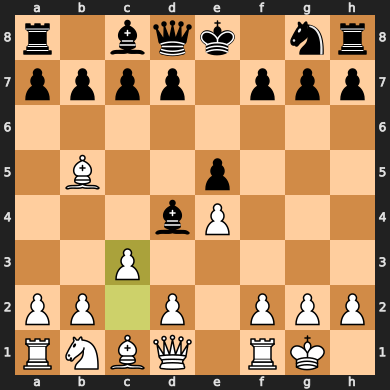

d4b6


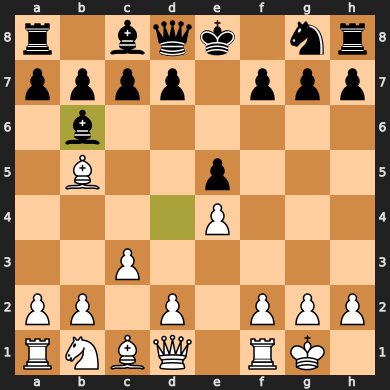

d2d4


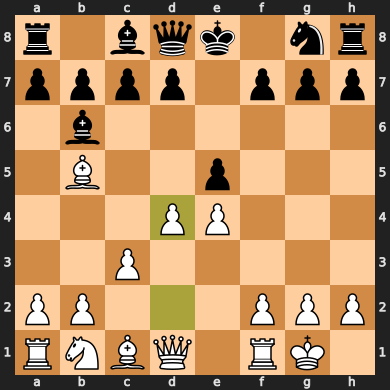

c7c6


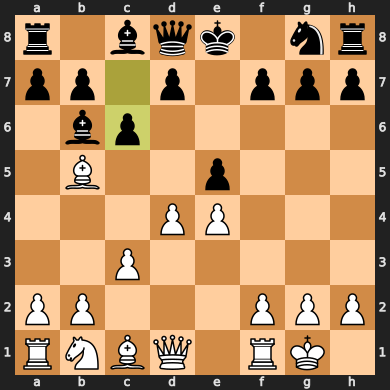

b5a4


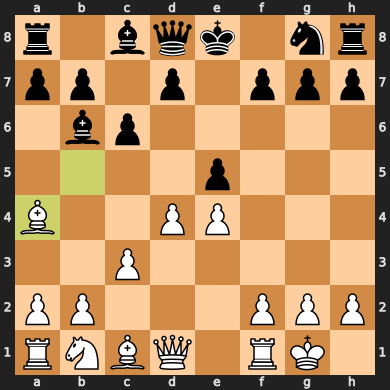

d7d6


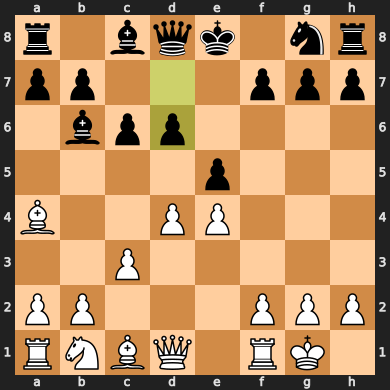

b1a3


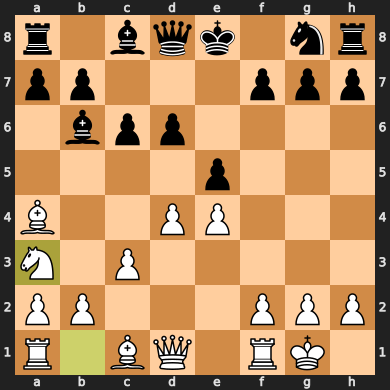

g8f6


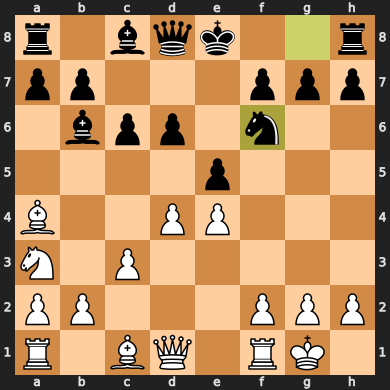

d1d3


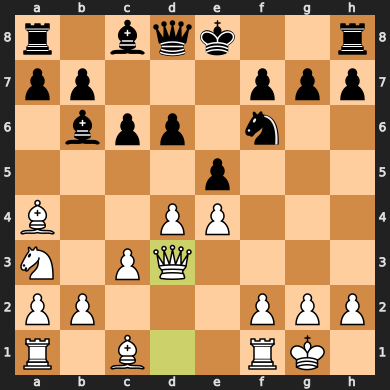

e8g8


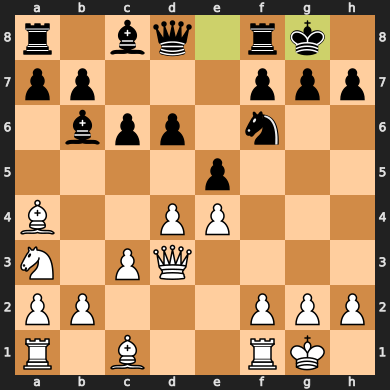

d4d5


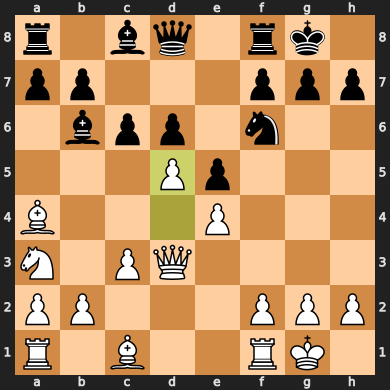

c6b8
Illegal move: c6b8


In [47]:
board = chess.Board()

for move in sampled_game:
    print(move)
    chess_move = chess.Move.from_uci(move)
    if chess_move in board.legal_moves:
        board.push(chess_move)
        display(board)
    else:
        print("Illegal move:", move)
        break

Once training works, the next step that makes it “real chess” is:

Legal-move masking during generation (using python-chess) so it never outputs illegal moves.